<br>

<h1 style="text-align:center;">Transformer</h1>

<br>

### INITIAL SETUP

---

In [1]:
# Import the libraries
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2023-07-03 14:39:24.492167: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-03 14:39:24.493841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 14:39:24.527477: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 14:39:24.528458: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 14:39:25.063880: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
### Hyperparameters

# Hyperpararmeters for the model
h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of model layers' outputs
d_ff = 2048  # Dimensionality of the inner fully connected layer
n = 6  # Number of layers in the encoder stack

# Hyperparameters for the training
epochs = 20
batch_size = 16
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
dropout_rate = 0.1

<br>

### DATASET LOADER

---

In [3]:
# Custom class for the dataset
class PrepareDataset:

    # Constructor function
    def __init__(self, **kwargs):

        # Inherite the parent's constructor
        super().__init__(**kwargs)

        # Initialization
        self.train_split = 0.8        # Train split ratio
        self.val_split = 0.1          # Validation split ratio

    # Function for creating and fitting a tokenizer to given dataset
    def create_tokenizer(self, dataset):
        """
        This function creates and fits a tokenizer to given dataset.

        PARAMETERS
        ===========================
            - dataset (list): list of sentences

        RETURNS
        ===========================
            - tokenizer (tensorflow tokenizer): fitted tokenizer
        """
        
        # Initialize a tokenizer
        tokenizer = tf.keras.preprocessing.text.Tokenizer()

        # Fit the tokenizer to the dataset
        tokenizer.fit_on_texts(dataset)

        return tokenizer
    
    # Function for finding the sequence length of the dataset
    def find_sequence_length(self, dataset):
        """
        This function finds the sequence length of the dataset.

        PARAMETERS
        ===========================
            - dataset (list): list of sentences

        RETURNS
        ===========================
            - sequence_length (int): sequence length of the dataset
        """

        # Sequence length
        sequence_length = max([len(i_seq.split()) for i_seq in dataset])

        return sequence_length
    
    # Function for finding the vocabulary size
    def find_vocabulary_size(self, tokenizer, dataset):
        """
        This function finds the vocabulary size of the dataset.

        PARAMETERS
        ===========================
            - tokenizer (tensorflow tokenizer): fitted tokenizer
            - dataset (list): list of sentences

        RETURNS
        ===========================
            - vocabulary_size (int): vocabulary size of the dataset
        """

        # Fit the tokenizer to the dataset
        tokenizer.fit_on_texts(dataset)

        # Vocabulary size
        vocabulary_size = len(tokenizer.word_index) + 1

        return vocabulary_size
    
    # Function for encoding and padding the input sequences
    def encode_and_pad(self, dataset, tokenizer, sequence_length):
        """
        This function encodes and pads the input sequences.

        PARAMETERS
        ===========================
            - dataset (list): list of sentences
            - tokenizer (tensorflow tokenizer): fitted tokenizer
            - sequence_length (int): sequence length of the dataset

        RETURNS
        ===========================
            - out (tensorflow tensor): encoded and padded dataset
        """

        # Encode the dataset
        encoded_dataset = tokenizer.texts_to_sequences(dataset)

        # Pad the dataset
        padded_dataset = tf.keras.preprocessing.sequence.pad_sequences(encoded_dataset, maxlen = sequence_length, padding = "post")

        # Convert the dataset into tensor
        out = tf.convert_to_tensor(padded_dataset, dtype=tf.int64)

        return out
    
    # Function for saving the tokenizer
    def save_tokenizer(self, tokenizer, name):
        """
        This function saves the tokenizer into a pickle file.

        PARAMETERS
        ===========================
            - tokenizer (tensorflow tokenizer): fitted tokenizer
            - name (str): name of the pickle file   

        RETURNS 
        ===========================
            - None
        """
        # Open the pickle file
        with open(name + "_tokenizer.pkl", "wb") as f:

            # Dump the tokenizer
            pickle.dump(tokenizer, f, protocol = pickle.HIGHEST_PROTOCOL)

    # Call function
    def __call__(self, filename, **kwargs):
                 
        # Load the dataset (already cleaned)
        dataset_clean = pickle.load(open(filename, "rb"))

        # TODO: Sample a subset of dataset
        # self.n_sentences = 10_000                  
        self.n_sentences = len(dataset_clean)

        # Sample a subset of the dataset
        dataset = dataset_clean[:self.n_sentences, :]

        # Add the START and EOS tokens to each sentence
        for i in range(dataset[:, 0].size):

            # Add the tokens to the sentences 
            dataset[i, 0] = "<START> " + dataset[i, 0] + " <EOS>"
            dataset[i, 1] = "<START> " + dataset[i, 1] + " <EOS>"

        # Shuffle the dataset
        np.random.shuffle(dataset)

        # Split the dataset into train, val, test
        train = dataset[:int(self.n_sentences * self.train_split)]
        val   = dataset[int(self.n_sentences * self.train_split)  :  int(self.n_sentences * (1 - self.val_split))]
        test  = dataset[int(self.n_sentences * (1 - self.val_split)) :]

        # Tokenization process for encoder input
        encoder_tokenizer       = self.create_tokenizer(dataset[:, 0])
        encoder_sequence_length = self.find_sequence_length(dataset[:, 0])
        encoder_vocabulary_size = self.find_vocabulary_size(encoder_tokenizer, train[:, 0])

        # Tokenization process for decoder input
        decoder_tokenizer       = self.create_tokenizer(dataset[:, 1])
        decoder_sequence_length = self.find_sequence_length(dataset[:, 1])
        decoder_vocabulary_size = self.find_vocabulary_size(decoder_tokenizer, train[:, 1])

        # Encode and pad the train dataset
        train_x = self.encode_and_pad(train[:, 0], encoder_tokenizer, encoder_sequence_length)
        train_y = self.encode_and_pad(train[:, 1], decoder_tokenizer, decoder_sequence_length)

        # Encode and pad the validation dataset
        val_x = self.encode_and_pad(val[:, 0], encoder_tokenizer, encoder_sequence_length)
        val_y = self.encode_and_pad(val[:, 1], decoder_tokenizer, decoder_sequence_length)

        # Save the encoder/decoder tokenizer
        self.save_tokenizer(encoder_tokenizer, "./saved/encoder")
        self.save_tokenizer(decoder_tokenizer, "./saved/decoder")

        # Save the testing dataset into a text file using savetxt
        np.savetxt("./saved/test_dataset.txt", test, fmt="%s")

        return (train_x, train_y, val_x, val_y, train, val, encoder_sequence_length, decoder_sequence_length, encoder_vocabulary_size, decoder_vocabulary_size)

In [4]:
# Test out the codes
if __name__ == "__main__":

    # Initialize the dataset class
    dataset = PrepareDataset()

    # Call it 
    train_x, train_y, val_x, val_y, train, val, encoder_sequence_length, decoder_sequence_length, encoder_vocabulary_size, decoder_vocabulary_size = dataset("./dataset/english-german-both.pkl")

    # Report
    print("Train X shape: ", train_x.shape)
    print("Train Y shape: ", train_y.shape)
    print("Val X shape: ", val_x.shape)
    print("Val Y shape: ", val_y.shape)
    print("Train shape: ", train.shape)
    print("Val shape: ", val.shape)
    print("Encoder sequence length: ", encoder_sequence_length)
    print("Decoder sequence length: ", decoder_sequence_length)
    print("Encoder vocabulary size: ", encoder_vocabulary_size)
    print("Decoder vocabulary size: ", decoder_vocabulary_size)
    print("Train X: ", train_x)
    print("Train Y: ", train_y)


Train X shape:  (8000, 7)
Train Y shape:  (8000, 12)
Val X shape:  (1000, 7)
Val Y shape:  (1000, 12)
Train shape:  (8000, 2)
Val shape:  (1000, 2)
Encoder sequence length:  7
Decoder sequence length:  12
Encoder vocabulary size:  2404
Decoder vocabulary size:  3864
Train X:  tf.Tensor(
[[   1    4    7 ... 1095    2    0]
 [   1   21    7 ...    5    2    0]
 [   1 1508    4 ...    0    0    0]
 ...
 [   1    4    7 ...    2    0    0]
 [   1  221    6 ...    2    0    0]
 [   1   22   19 ...  256    2    0]], shape=(8000, 7), dtype=int64)
Train Y:  tf.Tensor(
[[   1    5    4 ...    0    0    0]
 [   1    8    4 ...    0    0    0]
 [   1 1986   21 ...    0    0    0]
 ...
 [   1    5    4 ...    0    0    0]
 [   1 3464    7 ...    0    0    0]
 [   1    8   26 ...    0    0    0]], shape=(8000, 12), dtype=int64)


2023-07-03 14:39:26.617683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-03 14:39:26.619693: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


<br>

### POSITIONAL ENCODING

---

##### POSITION EMBEDDING LAYER

In [5]:
# POsition embedding layer
class PositionEmbeddingLayer(tf.keras.layers.Layer):

    # Constructor function
    def __init__(self, seq_length, vocab_size, output_dim, **kwargs):

        # Inherite the parent's constructor
        super().__init__(**kwargs)

        # Word embedding layer
        self.word_embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=output_dim)

        # Position embedding layer
        self.position_embedding_layer = tf.keras.layers.Embedding(input_dim=seq_length, output_dim=output_dim)

    # Call function
    def call(self, inputs):

        # Initialize the positions
        position_indices = tf.range(start=0, limit=tf.shape(inputs)[-1])

        # Feed words and positions to embedding layer
        embedded_words     = self.word_embedding_layer(inputs)
        embedded_positions = self.position_embedding_layer(position_indices)

        # Sum up the embeddings
        out = embedded_words + embedded_positions

        return out

In [6]:
# TEST THE CODE
if __name__=="__main__":

    # Hyperparameters
    output_length = 6
    output_sequence_length = 5
    vocab_size = 10

    # Sample text
    sentences = [["I am a robot"], ["you too robot"]]

    # Convert to tf.data
    sentence_data = tf.data.Dataset.from_tensor_slices(sentences)

    # Convert all sentences to tensors
    word_tensors = tf.convert_to_tensor(sentences, dtype=tf.string)
    
    # Vectorize the text
    vectorize_layer = tf.keras.layers.TextVectorization(output_sequence_length=output_sequence_length, max_tokens=vocab_size)
    vectorize_layer.adapt(sentence_data)
    vectorized_words = vectorize_layer(word_tensors)

    # Feed to the embedding layer
    my_embedding_layer = PositionEmbeddingLayer(output_sequence_length, vocab_size, output_length)
    embedded_layer_output = my_embedding_layer(vectorized_words)
    
    # Report
    print("Output from my_embedded_layer: ", embedded_layer_output)

Output from my_embedded_layer:  tf.Tensor(
[[[-2.4924435e-02  5.5890642e-02  3.3287253e-02  1.5423108e-02
    3.0362286e-02 -3.5833754e-02]
  [ 5.1383585e-02 -4.6783574e-03  2.8037265e-02  1.4657751e-02
    3.2689061e-02 -8.0875993e-02]
  [ 4.6030592e-02  4.2018507e-02  1.4287449e-02  3.3984926e-02
    2.1658257e-02 -8.8141680e-02]
  [-3.2368265e-03 -2.8120220e-02 -1.2495413e-02 -1.1844039e-03
    2.5623802e-02  2.8911199e-02]
  [-5.9241205e-03 -1.9663963e-02  3.4830939e-02 -2.6283884e-02
   -6.4223610e-02  1.4392287e-04]]

 [[ 1.5024196e-02  1.5852045e-02 -5.0491825e-02 -3.6675327e-02
    8.6241961e-02  4.7145970e-03]
  [-1.2702819e-02  3.6388449e-02  7.3169746e-02  9.1476686e-02
    4.3241873e-02  7.8938454e-03]
  [-2.6690863e-02  9.6485727e-03 -2.5635362e-03 -2.4817266e-02
    2.1782406e-03 -5.0211728e-02]
  [ 8.1039965e-05 -2.1956801e-02  4.1464616e-02 -1.3654804e-02
   -8.9165177e-03  6.4674452e-02]
  [-5.9241205e-03 -1.9663963e-02  3.4830939e-02 -2.6283884e-02
   -6.4223610e-02  

2023-07-03 14:39:26.834346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2,1]
	 [[{{node Placeholder/_0}}]]


##### POSITION EMBEDDING WITH FIXED WEIGHTS

In [7]:
# Positional embedding layer class with initializing the weights with sine/cosine function
class PositionEmbeddingLayerWithFixedWeights(tf.keras.layers.Layer):

    # Constructor function
    def __init__(self, seq_length, vocab_size, output_dim, **kwargs):

        # Inherite parent's constructor
        super().__init__(**kwargs)

        # Initialize the word / position embedding matrix (for initializing the weights with them)
        word_embedding_matrix     = self.get_position_encoding(vocab_size, output_dim)
        position_embedding_matrix = self.get_position_encoding(seq_length, output_dim)

        # Initialize the word / position embedding layer
        self.word_embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, 
                                                              output_dim=output_dim,
                                                              weights=[word_embedding_matrix],
                                                              trainable=False)
        self.position_embedding_layer = tf.keras.layers.Embedding(input_dim=seq_length,
                                                                  output_dim=output_dim,
                                                                  weights=[position_embedding_matrix],
                                                                  trainable=False
                                                                  )
        
    # Get position encoding (sine/cosine)
    def get_position_encoding(self, seq_len, d, n=10_000):

        # Initialize the positional matrix
        P = np.zeros(shape=(seq_len, d))

        # Loop over the range of sequence length
        for k in range(seq_len):

            # Loop over the index from 0 to d/2
            for i in np.arange(0, int(d/2)):

                # Denominator
                denominator = np.power(n, 2*i/d)

                # Sine
                P[k, 2*i] = np.sin(k/denominator)

                # Cosine
                P[k, 2*i+1] = np.cos(k/denominator)

        return P
    
    # Call function
    def call(self, inputs):

        # Initialize the position indices
        position_indices = tf.range(start=0, limit=tf.shape(inputs)[-1])

        # Feed the word and position data into the embedding layer
        embedded_words = self.word_embedding_layer(inputs)
        embedded_positions = self.position_embedding_layer(position_indices)

        # Sum up the embedding layers
        out = embedded_words + embedded_positions

        return out

In [8]:
# TEST THE CODE
if __name__=="__main__":

    # Hyperparameters
    output_length = 6
    output_sequence_length = 5
    vocab_size = 10

    # Sample text
    sentences = [["I am a robot"], ["you too robot"]]

    # Convert to tf.data
    sentence_data = tf.data.Dataset.from_tensor_slices(sentences)
    
    # Convert all sentences to tensors
    word_tensors = tf.convert_to_tensor(sentences, dtype=tf.string)
    
    # Vectorize the text
    vectorize_layer = tf.keras.layers.TextVectorization(output_sequence_length=output_sequence_length, max_tokens=vocab_size)
    vectorize_layer.adapt(sentence_data)
    vectorized_words = vectorize_layer(word_tensors)

    # Feed to the embedding layer
    attnisallyouneed_embedding = PositionEmbeddingLayerWithFixedWeights(output_sequence_length, vocab_size, output_length)
    attnisallyouneed_output = attnisallyouneed_embedding(vectorized_words)
    
    # Report
    print("Output from my_embedded_layer: ", attnisallyouneed_output)



2023-07-03 14:39:27.012522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2,1]
	 [[{{node Placeholder/_0}}]]


Output from my_embedded_layer:  tf.Tensor(
[[[-0.9589243   1.2836622   0.23000172  1.9731903   0.01077196
    1.9999421 ]
  [ 0.56205547  1.5004725   0.3213085   1.9603932   0.01508068
    1.9999142 ]
  [ 1.566284    0.3377554   0.41192317  1.9433732   0.01938933
    1.999877  ]
  [ 1.0504174  -1.4061394   0.2314966   1.9860148   0.01077211
    1.9999698 ]
  [-0.7568025   0.3463564   0.18459873  1.982814    0.00861763
    1.9999628 ]]

 [[ 0.14112     0.0100075   0.1387981   1.9903207   0.00646326
    1.9999791 ]
  [ 0.08466846 -0.11334133  0.23099795  1.9817369   0.01077207
    1.9999605 ]
  [ 1.8185948  -0.8322937   0.185397    1.9913884   0.00861771
    1.9999814 ]
  [ 0.14112     0.0100075   0.1387981   1.9903207   0.00646326
    1.9999791 ]
  [-0.7568025   0.3463564   0.18459873  1.982814    0.00861763
    1.9999628 ]]], shape=(2, 5, 6), dtype=float32)


<br>

### ATTENTION

---

In [9]:
# Scaled dot product attention class
class ScaledDotProductAttentionLayer(tf.keras.layers.Layer):

    # Constructor function
    def __init__(self, **kwargs):

        # Inherite the parent's constructor
        super().__init__(**kwargs)


    # Call function
    def call(self, queries, keys, values, d_k, mask=None):

        # Attention score
        attention_score = tf.matmul(queries, keys, transpose_b=True) / tf.math.sqrt(tf.cast(d_k, tf.float32))

        # Apply mask
        if mask is not None:
            attention_score += (-1e9 * mask)

        # Apply softmax
        weights = tf.keras.backend.softmax(attention_score)

        # Calculate the weighted sum 
        out = tf.matmul(weights, values)

        return out


In [10]:
# TEST THE CODE
if __name__=="__main__":

    # Hyperparameters
    input_seq_length = 5    # Maximum length of the input sequence
    d_k = 64                # Dimensionality of the linearly projected queries and keys
    d_v = 64                # Dimensionality of the linearly projected values
    batch_size = 64         # Batch size from the training process

    # Initialize the queries, keys, values randomely
    queries = np.random.random((batch_size, input_seq_length, d_k))
    keys    = np.random.random((batch_size, input_seq_length, d_k))
    values  = np.random.random((batch_size, input_seq_length, d_v))

    # Feed to the attention layer
    attention = ScaledDotProductAttentionLayer()
    out = attention(queries, keys, values, d_k)

    # Report
    print("Output from the attention layer: ", out)

Output from the attention layer:  tf.Tensor(
[[[0.4975923  0.40308696 0.5376995  ... 0.43953294 0.40770963 0.5057981 ]
  [0.49572456 0.41930145 0.54521567 ... 0.46037316 0.40874925 0.49132714]
  [0.48554596 0.4018998  0.54402006 ... 0.44024646 0.4166857  0.5141643 ]
  [0.50080734 0.41860065 0.5461656  ... 0.44185263 0.41294837 0.49832794]
  [0.5152608  0.40915662 0.52903247 ... 0.43702582 0.39840442 0.50156784]]

 [[0.44245288 0.18936467 0.59702444 ... 0.49811876 0.5584522  0.5803972 ]
  [0.4383108  0.18972366 0.61596805 ... 0.48022068 0.55336654 0.5747172 ]
  [0.44158235 0.18540372 0.61093885 ... 0.4716351  0.5642079  0.56254625]
  [0.4432204  0.1895485  0.6068978  ... 0.47909385 0.5616576  0.56953514]
  [0.43783954 0.19278497 0.6065576  ... 0.48845467 0.5533936  0.5799821 ]]

 [[0.5352766  0.5337863  0.59896123 ... 0.48238063 0.5877674  0.62280047]
  [0.5182316  0.55643034 0.61300975 ... 0.47924885 0.56121916 0.611951  ]
  [0.5643305  0.5348186  0.5899037  ... 0.4535912  0.6183972  0

In [11]:
# Multi-head attention class
class MultiHeadAttentionLayer(tf.keras.layers.Layer):

    # Constructor function
    def __init__(self, h, d_k, d_v, d_model, **kwargs):

        # Inherite the parent's constructor
        super().__init__(**kwargs)

        # Initialize the scaled dot product attention layer
        self.attention = ScaledDotProductAttentionLayer()

        # Initialization
        self.heads = h            # Number of attention heads
        self.d_k = d_k            # Dimension of the key vector (and also the query vector)
        self.d_v = d_v            # Dimension of the value vector
        self.d_model = d_model    # Dimension of the model

        # Initialize dense layer for learned projection matrix for queries, keys, values, and model
        self.W_q = tf.keras.layers.Dense(units=d_k)
        self.W_k = tf.keras.layers.Dense(units=d_k)
        self.W_v = tf.keras.layers.Dense(units=d_v)
        self.W_o = tf.keras.layers.Dense(units=d_model)


    # Function for reshaping the tensor 
    def reshape_tensor(self, x, heads, flag):

        # If flag is on
        # Used when recieving the linearly projected queries, keys, or values as input
        # Final shape should be: (batch_size, heads, seq_length, -1)
        if flag:

            # Reshape the tensor
            x = tf.reshape(x, shape=(tf.shape(x)[0], tf.shape(x)[1], heads, -1))

            # Transpose the tensor
            x = tf.transpose(x, perm=(0, 2, 1, 3))

        # If flag is off
        # Use after the data feeded into the multi head attention layer
        # Final shape should be: (batch_size, seq_length, d_k)
        else:

            # Transpose
            x = tf.transpose(x, perm=(0, 2, 1, 3))

            # Reshape
            x = tf.reshape(x, shape=(tf.shape(x)[0], tf.shape(x)[1], self.d_k))

        return x
    

    # Call function
    def call(self, queries, keys, values, mask=None):

        # Reshape queries, keys, values to be able to compute all heads in parallel
        queries_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
        keys_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        values_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
        
        # Compute multi-head attention
        output_reshaped = self.attention(queries_reshaped, keys_reshaped, values_reshaped, self.d_k, mask)

        # Rearrange the output into concatenated form
        output = self.reshape_tensor(output_reshaped, self.heads, False)

        # Apply the linear projection to the output
        output = self.W_o(output)

        return output

In [12]:
# TEST THE CODE
if __name__=="__main__":

    # Hyperparameters
    input_seq_length = 5    # Maximum length of the input sequence
    h = 8                   # Number of self-attention heads
    d_k = 64                # Dimensionality of the linearly projected queries and keys
    d_v = 64                # Dimensionality of the linearly projected values
    d_model = 512           # Dimensionality of the model sub-layers' outputs
    batch_size = 64         # Batch size from the training process

    # Initialize the queries, keys, values randomely
    queries = np.random.random((batch_size, input_seq_length, d_k))
    keys    = np.random.random((batch_size, input_seq_length, d_k))
    values  = np.random.random((batch_size, input_seq_length, d_v))

    # Feed to the multi-head attention layer
    multihead_attention = MultiHeadAttentionLayer(h, d_k, d_v, d_model)
    out = multihead_attention(queries, keys, values)

    # Report
    print("Output from the multi-head attention layer: ", out)



Output from the multi-head attention layer:  tf.Tensor(
[[[-1.66469619e-01  1.63553625e-01 -1.36685461e-01 ... -5.46096712e-02
    2.07701206e-01  4.19217208e-03]
  [-1.64007828e-01  1.63331047e-01 -1.39813229e-01 ... -5.35636432e-02
    2.07937583e-01  1.66530185e-03]
  [-1.64741859e-01  1.65688321e-01 -1.38286382e-01 ... -5.55306152e-02
    2.07518727e-01  1.68163725e-03]
  [-1.66954830e-01  1.68592140e-01 -1.38605982e-01 ... -5.26690148e-02
    2.08170936e-01 -2.56264728e-04]
  [-1.68323398e-01  1.66108802e-01 -1.37974724e-01 ... -5.30769862e-02
    2.07550332e-01  2.89576175e-03]]

 [[-2.06464544e-01  1.51354447e-01 -1.83266789e-01 ... -1.02626972e-01
    1.95411921e-01  1.12775676e-01]
  [-2.11605936e-01  1.46915451e-01 -1.80304363e-01 ... -1.03469551e-01
    1.96917787e-01  1.14309050e-01]
  [-2.09931299e-01  1.48911923e-01 -1.78512841e-01 ... -1.05035760e-01
    1.94795027e-01  1.13725916e-01]
  [-2.08803311e-01  1.46946937e-01 -1.78783491e-01 ... -1.03333235e-01
    1.93902045e

<br>

### MASKING

---

In [13]:
# Function for masking the paddings
def padding_mask(inputs):

    # Create mask (i.e. marks zero paddings by a 1 and 0 elsewhere)
    mask = tf.math.equal(inputs, 0)
    mask = tf.cast(mask, tf.float32)

    return mask

In [14]:
# Function for lookahead mask
def lookahead_mask(shape):

    # Create mask (i.e. marks future enteries by a 1 and 0 elsewhere)
    mask = 1 - tf.linalg.band_part(tf.ones((shape, shape)), num_lower=-1, num_upper=0)

    return mask

In [15]:
# TEST THE CODE
if __name__=="__main__":

    # Sample dataset
    inputs = np.array([1, 2, 3, 4, 0, 0, 0])
    
    # Apply padding mask
    masked_inputs = padding_mask(inputs)
    
    # Apply lookahead mask
    masked_lookahead = lookahead_mask(shape=5)

    # Report
    print("Inputs: ", inputs)
    print("Masked inputs: ", masked_inputs)
    print("Masked lookahead of shape 5: ", masked_lookahead)

Inputs:  [1 2 3 4 0 0 0]
Masked inputs:  tf.Tensor([0. 0. 0. 0. 1. 1. 1.], shape=(7,), dtype=float32)
Masked lookahead of shape 5:  tf.Tensor(
[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)


<br>

### ENCODER

---

In [16]:
# Custom layer for Add & Norm layer
class AddNormalizationLayer(tf.keras.layers.Layer):

    # Constructor function
    def __init__(self, **kwargs):

        # Inherite the parent's constructor
        super().__init__(**kwargs)

        # Initialize the layer normalization layer
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # Call function
    def call(self, x, sublayer_x):

        # Add the sublayer input and output together
        add = x + sublayer_x

        # Apply layer normalization
        out = self.layer_norm(add)

        return out

In [17]:
# Custom layer for Feed-Forward layer
class FeedForwardLayer(tf.keras.layers.Layer):

    # Constructor function
    def __init__(self, d_ff, d_model, **kwargs):

        # Inherite the parent's constructor
        super().__init__(**kwargs)

        # Initialize the dense layers
        self.fully_connected_1 = tf.keras.layers.Dense(units=d_ff)
        self.fully_connected_2 = tf.keras.layers.Dense(units=d_model)

        # Initialize the activation function
        self.activation = tf.keras.layers.ReLU()

    # Call function
    def call(self, x):

        # Feed the data
        x = self.fully_connected_1(x)
        x = self.activation(x)
        x = self.fully_connected_2(x)

        return x

In [18]:
# Custom layer for Transformer Encoder
class EncoderLayer(tf.keras.layers.Layer):

    # Constructor function
    def __init__(self, sequence_length, h, d_k, d_v, d_model, d_ff, rate, **kwargs):

        # Inherite the parent's constructor
        super().__init__(**kwargs)

        # Initialization (to use in rest of the class)
        self.sequence_length = sequence_length 
        self.d_model = d_model

        # Attention layer
        self.multihead_attention = MultiHeadAttentionLayer(h, d_k, d_v, d_model)

        # Feed-forward layer
        self.feed_forward = FeedForwardLayer(d_ff, d_model)

        # Add & Norm layer
        self.add_norm_1 = AddNormalizationLayer()
        self.add_norm_2 = AddNormalizationLayer()

        # Dropout layer
        self.dropout_1 = tf.keras.layers.Dropout(rate)
        self.dropout_2 = tf.keras.layers.Dropout(rate)

        # Build the model (form model summary)
        self.build(input_shape=[None, sequence_length, d_model])

    # Build function
    def build_graph(self):

        # Construct the model
        input_layer = tf.keras.layers.Input(shape=(self.sequence_length, self.d_model))
        return tf.keras.Model(inputs=[input_layer], outputs=self.call(input_layer, None, True))

    # Call function
    def call(self, x, padding_mask, training):

        # Feed the data
        multihead_output   = self.multihead_attention(x, x, x, padding_mask)
        multihead_output   = self.dropout_1(multihead_output, training=training)
        addnorm_output     = self.add_norm_1(x, multihead_output)
        feedforward_output = self.feed_forward(addnorm_output)
        feedforward_output = self.dropout_2(feedforward_output, training=training)
        addnorm_output     = self.add_norm_2(addnorm_output, feedforward_output)

        return addnorm_output

In [19]:
# Custom layer for the full model
class Encoder(tf.keras.layers.Layer):

    # Constructor function
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):

        # Inherite the parent's constructor
        super().__init__(**kwargs)

        # Positional encoding layer
        self.positional_encoding = PositionEmbeddingLayerWithFixedWeights(sequence_length, vocab_size, d_model)

        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(rate)

        # Encoder layers (for N times)
        self.encoder_layer = [EncoderLayer(sequence_length, h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

    # Call function
    def call(self, input_sentence, padding_mask, training):

        # Feed the data
        x = self.positional_encoding(input_sentence)
        x = self.dropout(x, training=training) 
        for i_index, i_layer in enumerate(self.encoder_layer):
            x = i_layer(x, padding_mask, training)

        return x

In [20]:
# TEST THE CODE
if __name__=="__main__":

    # Hyperparameters
    h = 8                     # Number of self-attention heads
    d_k = 64                  # Dimension of the key and query vectors
    d_v = 64                  # Dimension of the value vectors
    d_ff = 2048               # Dimension of the inner feed-forward layer
    d_model = 512             # Dimension of the mode syb-layer' output
    n = 6                     # Number of encoder layers
    batch_size = 64           # Batch size
    dropout_rate = 0.1        # Dropout rate
    enc_vocab_size = 8192     # Encoder vocabulary size
    input_seq_length = 64     # Maximum length of the input sequence

    # Sample input dataset
    input_seq = np.random.random((batch_size, input_seq_length))

    # Feed to the encoder
    encoder = Encoder(enc_vocab_size, input_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
    output_encoder = encoder(input_seq, None, True)
    
    # Model summary
    encoder_layer = EncoderLayer(input_seq_length, h, d_k, d_v, d_model, d_ff, dropout_rate)
    
    # Report
    print("Model summary: ", encoder_layer.build_graph().summary())
    print("Output of the encoder: \n", output_encoder)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 512)]    0           []                               
                                                                                                  
 multi_head_attention_layer_7 (  (None, 64, 512)     131776      ['input_1[0][0]',                
 MultiHeadAttentionLayer)                                         'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 dropout_13 (Dropout)           (None, 64, 512)      0           ['multi_head_attention_layer_7[0]
                                                                 [0]']                        

<br>

### DECODER

---

In [21]:
# Custom layer for decoder layer
class DecoderLayer(tf.keras.layers.Layer):

    # Constructor function
    def __init__(self, sequence_length, h, d_k, d_v, d_model, d_ff, rate, **kwargs):

        # Inherite parent's constructor
        super().__init__(**kwargs)

        # Multi-head attention layer
        self.multihead_attention_1 = MultiHeadAttentionLayer(h, d_k, d_v, d_model)
        self.multihead_attention_2 = MultiHeadAttentionLayer(h, d_k, d_v, d_model)

        # Feed-forward layer
        self.feed_forward = FeedForwardLayer(d_ff, d_model)

        # Add & Norm layer
        self.add_norm_1 = AddNormalizationLayer()
        self.add_norm_2 = AddNormalizationLayer()
        self.add_norm_3 = AddNormalizationLayer()

        # Dropout layer
        self.dropout_1 = tf.keras.layers.Dropout(rate)
        self.dropout_2 = tf.keras.layers.Dropout(rate)
        self.dropout_3 = tf.keras.layers.Dropout(rate)

        # Initialization
        self.sequence_length = sequence_length
        self.d_model = d_model

        # Build the model (for model summary)
        self.build(input_shape=[None, sequence_length, d_model])

    # Build function
    def build_graph(self):

        # Construct the model
        input_layer = tf.keras.layers.Input(shape=(self.sequence_length, self.d_model))
        return tf.keras.Model(inputs=[input_layer], outputs=self.call(input_layer, input_layer, None, None, True))

    # Call function
    def call(self, x, encoder_output, lookahead_mask, padding_mask, training):

        # Feed the data
        multihead_output_1 = self.multihead_attention_1(x, x, x, lookahead_mask)
        multihead_output_1 = self.dropout_1(multihead_output_1, training=training)
        addnorm_output_1 = self.add_norm_1(x, multihead_output_1)

        multihead_output_2 = self.multihead_attention_2(addnorm_output_1, encoder_output, encoder_output, padding_mask)
        multihead_output_2 = self.dropout_2(multihead_output_2, training=training)
        addnorm_output_2 = self.add_norm_2(addnorm_output_1, multihead_output_2)

        feedforward_output = self.feed_forward(addnorm_output_2)
        feedforward_output = self.dropout_3(feedforward_output, training=training)
        addnorm_output_3 = self.add_norm_3(addnorm_output_2, feedforward_output)

        return addnorm_output_3

In [22]:
# Custom layer for the full decoder model
class Decoder(tf.keras.layers.Layer):

    # Constructor function
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate, **kwargs):

        # Inherite the parent's constructor
        super().__init__(**kwargs)

        # Positional encoding layer
        self.pos_encoding = PositionEmbeddingLayerWithFixedWeights(sequence_length, vocab_size, d_model)

        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(rate)

        # Decoder layers (for N times)
        self.decoder_layer = [DecoderLayer(sequence_length, h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]

    # Call function
    def call(self, output_target, encoder_output, lookahead_mask, padding_mask, training):

        # Feed the data
        x = self.pos_encoding(output_target)
        x = self.dropout(x, training=training)
        for i_index, i_layer in enumerate(self.decoder_layer):
            x = i_layer(x, encoder_output, lookahead_mask, padding_mask, training)

        return x

In [23]:
# TEST THE CODE
if __name__=="__main__":

    # Hyperparameters
    h = 8                  # Number of heads
    d_k = 64               # Dimension of the key and query vectors
    d_v = 64               # Dimension of the value vectors
    d_ff = 2048            # Dimension of the feed-forward layer
    d_model = 512          # Dimension of the model sub-layer' output
    n = 6                  # Number of encoder layers
    batch_size = 64        # Batch size
    dropout_rate = 0.1     # Dropout rate
    dec_vocab_size = 8000  # Decoder vocabulary size
    input_seq_length = 40  # Input sequence length

    # Sample dataset
    input_seq = np.random.random((batch_size, input_seq_length))
    encoder_output = np.random.random((batch_size, input_seq_length, d_model))
    
    # Feed to the decoder
    decoder = Decoder(dec_vocab_size, input_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)
    output_target = decoder(input_seq, encoder_output, None, True)

    # Model summary
    decoder_layer = DecoderLayer(input_seq_length, h, d_k, d_v, d_model, d_ff, dropout_rate)
    
    # Print
    print("Model summary: ", decoder_layer.build_graph().summary())
    print("Decoder Output: ", output_target)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40, 512)]    0           []                               
                                                                                                  
 multi_head_attention_layer_20   (None, 40, 512)     131776      ['input_2[0][0]',                
 (MultiHeadAttentionLayer)                                        'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dropout_34 (Dropout)           (None, 40, 512)      0           ['multi_head_attention_layer_20[0
                                                                 ][0]']                     

<br>

### TRANSFORMER

---

In [24]:
# Custom class for transformer mode
class TransformerModel(tf.keras.Model):

    # Constructor function
    def __init__(self, enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate, **kwargs):

        # Inherite the parent's constructor
        super().__init__(**kwargs)

        # Encoder model
        self.encoder = Encoder(enc_vocab_size, enc_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate)

        # Decoder model
        self.decoder = Decoder(dec_vocab_size, dec_seq_length, h, d_k, d_v, d_model, d_ff_inner, n, rate)

        # Dense layer
        self.last_layer = tf.keras.layers.Dense(dec_vocab_size)

    # Function for masking the padding
    def padding_mask(self, inputs):

        # Create mask (i.e. marks zero paddings by a 1 and 0 elsewhere)
        mask = tf.math.equal(inputs, 0)
        mask = tf.cast(mask, tf.float32)

        # Make the shape broadcastable for the attention weights
        mask = mask[:, tf.newaxis, tf.newaxis, :]

        return mask
    
    # Function for masking the lookahead
    def lookahead_mask(self, shape):

        # Create mask (i.e. marks future words by a 1 and 0 elsewhere)
        mask = 1 - tf.linalg.band_part(tf.ones((shape, shape)), -1, 0)

        return mask
    
    # Function for calling the model
    def call(self, encoder_input, decoder_input, training):

        # Mask the paddings for input data 
        enc_padding_mask = self.padding_mask(encoder_input)
        dec_in_padding_mask = self.padding_mask(decoder_input)

        # Mask the lookahead
        dec_in_lookahead_mask = self.lookahead_mask(decoder_input.shape[1])
        dec_in_lookahead_mask = tf.maximum(dec_in_padding_mask, dec_in_lookahead_mask)

        # Feed to encoder
        encoder_output = self.encoder(encoder_input, enc_padding_mask, training)

        # Feed to decoder
        decoder_output = self.decoder(decoder_input, encoder_output, dec_in_lookahead_mask, enc_padding_mask, training)

        # Feed to the last layer
        model_output = self.last_layer(decoder_output)



        return model_output

In [25]:
# TEST THE CODE
if __name__=="__main__":

    # Hyperparaneters
    enc_vocab_size = 20   # Vocabulary size for the encoder
    dec_vocab_size = 20   # Vocabulary size for the decoder
    enc_seq_length = 5    # Maximum length of the input sequence
    dec_seq_length = 5    # Maximum length of the target sequence
    h = 8                 # Number of self-attention heads
    d_k = 64              # Dimensionality of the linearly projected queries and keys
    d_v = 64              # Dimensionality of the linearly projected values
    d_ff = 2048           # Dimensionality of the inner fully connected layer
    d_model = 512         # Dimensionality of the model sub-layers' outputs
    n = 6                 # Number of layers in the encoder stack
    dropout_rate = 0.1    # Frequency of dropping the input units in the dropout layers

    # Create model
    training_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)

    print(training_model)

<br>

### TRAINING

---

In [26]:
# Class for scheduling the learning ear
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    This class schedules the learning rate.

    PARAMETERS
    ==========================
        - d_model (int): the model's dimensionality
        - warmup_steps (int): the number of warmup steps
        
    RETURNS
    ==========================
        - learning_rate (tf.Tensor): the learning rate
    """
    
    # Constructor function
    def __init__(self, d_model, warmup_steps=4_000, **kwargs):

        # Inherite the parent's constructor
        super().__init__(**kwargs)

        # Initializations
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    # Call function
    def __call__(self, step_num):

        # Cast step_num to float
        step_num = tf.cast(step_num, tf.float32)

        # Linearly increase the learning rate for the first warmup_steps times, then decrease it
        arg1 = step_num ** -0.5
        arg2 = step_num * (self.warmup_steps ** -1.5)

        # Learning rate
        learning_rate = (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

        return learning_rate

In [27]:
# Instantiate the optimizer with the learning rate scheduler
optimizer = tf.keras.optimizers.Adam(LearningRateScheduler(d_model), beta_1, beta_2, epsilon)

# Prepare the dataset
dataset = PrepareDataset()
train_x, train_y, val_x, val_y, train, val, encoder_sequence_length, decoder_sequence_length, encoder_vocabulary_size, decoder_vocabulary_size = dataset("./dataset/english-german-both.pkl")

# Convert to tf.data
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
val_dataset = val_dataset.batch(batch_size)

# Instantiate the model
model = TransformerModel(encoder_vocabulary_size, decoder_vocabulary_size, encoder_sequence_length, decoder_sequence_length, h, d_k, d_v, d_model, d_ff, n, dropout_rate)

# Include the metrics monitoring
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.Mean(name="train_accuracy")
val_loss = tf.keras.metrics.Mean(name="val_loss")

# Checkpoint object and manager (for managing multiple checkpoints)
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, "./checkpoints", max_to_keep=None)

# Initialize lists for stroing the losses
train_loss_d = {}
val_loss_d = {}

In [28]:
# Function for calculating the loss
def loss_function(target, prediction):
    """
    This function calculates the loss between the target and the prediction.

    PARAMETERS
    ==========================
        - target (tf.Tensor): the target tensor
        - prediction (tf.Tensor): the prediction tensor

    RETURNS
    ==========================
        - loss (tf.Tensor): the loss between the target and the prediction
    """

    # Mask the padding values
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    mask = tf.cast(mask, tf.float32)

    # Computer the sparse categorical cross entropy loss on the unmasked values
    loss = tf.keras.losses.sparse_categorical_crossentropy(target, prediction, from_logits=True) * mask

    # Calculate the mean loss over the unmasked values
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)

    return loss

In [29]:
# Function for calculating the accuracy
def accuracy_function(target, prediction):
    """
    Function for calculating the accuracy between the target and the prediction.

    PARAMETERS
    ==========================
        - target (tf.Tensor): the target tensor
        - prediction (tf.Tensor): the prediction tensor

    RETURNS
    ==========================
        - out (tf.Tensor): the accuracy between the target and the prediction
    """

    # Mask the padding values
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    
    # Calculate accuracy and apply the padding mask
    accuracy = tf.equal(target, tf.argmax(prediction, axis=2))
    accuracy = tf.math.logical_and(mask, accuracy)

    # Cast the accuracy from boolean to float32
    mask = tf.cast(mask, dtype=tf.float32)
    accuracy = tf.cast(accuracy, dtype=tf.float32)

    # Calculate the mean accuracy over the unmasked values
    out = tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    return out

In [30]:
# Function for the training step (to spped up the training process)
@tf.function
def train_step(encoder_input, decoder_input, decoder_output):
    """
    This function performs a training step.

    PARAMETERS
    ==========================
        - encoder_input (tf.Tensor): the encoder input
        - decoder_input (tf.Tensor): the decoder input
        - decoder_output (tf.Tensor): the decoder output

    RETURNS
    ==========================
        - None
    """

    # Initialize the gradient tape
    with tf.GradientTape() as tape:

        # Forward pass (to make predictions)
        prediction = model(encoder_input, decoder_input, training=True)

        # Calculate loss
        loss = loss_function(decoder_output, prediction)

        # Calculate accuracy
        accuracy = accuracy_function(decoder_output, prediction)

    # Fetch the gradients of the trainable variables with respect to the training loss
    gradients = tape.gradient(loss, model.trainable_weights)

    # Apply the gradients to the optimizer so it can update the model accordingly
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    # Update the metrics
    train_loss(loss)
    train_accuracy(accuracy)

In [31]:
# Loop over the epochs
for i_epoch in range(epochs):

    # Reset the metrics
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()

    # Report 
    print(f"Epoch {i_epoch + 1}/{epochs}" + "\n===========================================")

    # Start a timer
    start_time = time.time()

    # Loop over the training batches
    for i_step, (train_batch_x, train_batch_y) in enumerate(train_dataset):

        # Define the encoder/decoder input/output
        encoder_input = train_batch_x[:, 1:]
        decoder_input = train_batch_y[:, :-1]
        decoder_output = train_batch_y[:, 1:]

        # Perform one training step
        train_step(encoder_input, decoder_input, decoder_output)

        # Report
        if (i_step % 50 == 0):
            print(f"Step {i_step}, Loss = {train_loss.result():.4f}, Accuracy = {train_accuracy.result():.4f}")

    # Loop over the validation batches
    for i_step, (val_batch_x, val_batch_y) in enumerate(val_dataset):

        # Define the encoder/decoder input/output
        encoder_input = val_batch_x[:, 1:]
        decoder_input = val_batch_y[:, :-1]
        decoder_output = val_batch_y[:, 1:]

        # Forward pass (to make predictions)
        prediction = model(encoder_input, decoder_input, training=False)

        # Calculate the loass
        loss = loss_function(decoder_output, prediction)

        # Update the metrics
        val_loss(loss)

        # Reoirt
        if (i_step % 50 == 0):
            print(f"Step {i_step}, Validation Loss = {val_loss.result():.4f}")


    # Report
    print(f"Training Loss = {train_loss.result():.4f}, Training Accuracy = {train_accuracy.result():.4f}, Validation Loss = {val_loss.result():.4f}")

    # Save the checkpoint after each epoch
    if (i_epoch+1) % 1 == 0:

        # Save the checkpoint
        save_path = checkpoint_manager.save()

        # Report
        print(f"Checkpoint saved at {save_path}.")

        # Save the weights
        model.save_weights("weights/wghts" + str(i_epoch + 1) + ".ckpt")

        # Report
        train_loss_d[i_epoch] = train_loss.result()
        val_loss_d[i_epoch] = val_loss.result()

# Save the loss values
with open("./train_loss.pkl", "wb") as file:  pickle.dump(train_loss_d, file)
with open("./val_loss.pkl", "wb") as file:  pickle.dump(val_loss_d, file)

Epoch 1/20


2023-07-03 14:39:46.811449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [8000,12]
	 [[{{node Placeholder/_1}}]]


Step 0, Loss = 8.3777, Accuracy = 0.0000
Step 50, Loss = 7.6837, Accuracy = 0.1296
Step 100, Loss = 7.0861, Accuracy = 0.1743


2023-07-03 14:41:05.732014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1000,12]
	 [[{{node Placeholder/_1}}]]


Step 0, Validation Loss = 5.7459
Training Loss = 6.8868, Training Accuracy = 0.1850, Validation Loss = 5.7710
Checkpoint saved at ./checkpoints/ckpt-1.
Epoch 2/20
Step 0, Loss = 5.8012, Accuracy = 0.2786
Step 50, Loss = 5.6080, Accuracy = 0.2747
Step 100, Loss = 5.4230, Accuracy = 0.2808
Step 0, Validation Loss = 5.0551
Training Loss = 5.3390, Training Accuracy = 0.2835, Validation Loss = 4.9494
Checkpoint saved at ./checkpoints/ckpt-2.
Epoch 3/20
Step 0, Loss = 4.8491, Accuracy = 0.3143
Step 50, Loss = 4.7965, Accuracy = 0.3077
Step 100, Loss = 4.6796, Accuracy = 0.3217
Step 0, Validation Loss = 4.5852
Training Loss = 4.6249, Training Accuracy = 0.3284, Validation Loss = 4.3817
Checkpoint saved at ./checkpoints/ckpt-3.
Epoch 4/20
Step 0, Loss = 4.3557, Accuracy = 0.3571
Step 50, Loss = 4.2781, Accuracy = 0.3670
Step 100, Loss = 4.1918, Accuracy = 0.3779
Step 0, Validation Loss = 4.2525
Training Loss = 4.1533, Training Accuracy = 0.3821, Validation Loss = 4.0401
Checkpoint saved at ./c

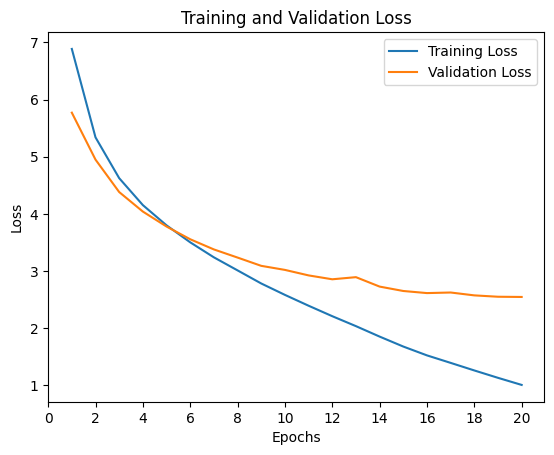

In [32]:
#######################
#    VISUALIZATION    #
#######################

# Load the training and validation loss dictionaries
train_loss = pickle.load(open('train_loss.pkl', 'rb'))
val_loss = pickle.load(open('val_loss.pkl', 'rb'))

# Retrieve each dictionary's values
train_values = train_loss.values()
val_values = val_loss.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 21)

# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(np.arange(0, 21, 2))

# Display the plot
plt.legend(loc='best')
plt.show()

<br>

### INFERENCE

---

In [33]:
# Custom class for inference
class Inference(tf.Module):

    # Constructor function
    def __init__(self, inferencing_model, **kwargs):
        
        # Inherite the parent's constructor
        super().__init__(**kwargs)

        # Initialize the model
        self.transformer = inferencing_model

    # Function for loading the tokenizer
    def load_tokenizer(self, name):

        # Load the tokenizer from the specified file
        with open(name, 'rb') as handle: return pickle.load(handle)

    # Call function
    def __call__(self, sentence):

        # Append START and EOS tokens to the input sentence
        sentence[0] = "<START> " + sentence[0] + " <EOS>"

        # Load tokenizers for encoder and decoder
        enc_tokenizer = self.load_tokenizer('./saved/encoder_tokenizer.pkl')
        dec_tokenizer = self.load_tokenizer('./saved/decoder_tokenizer.pkl')

        # Encoder input; tokenizing, padding and converting to tensor
        encoder_input = enc_tokenizer.texts_to_sequences(sentence)
        encoder_input = tf.keras.preprocessing.sequence.pad_sequences(encoder_input, maxlen=enc_seq_length, padding='post')
        encoder_input = tf.convert_to_tensor(encoder_input, dtype=tf.int64)

        # Start of the output sequence is with the <START> token
        output_start = dec_tokenizer.texts_to_sequences(["<START>"])            # Convert to integers
        output_start = tf.convert_to_tensor(output_start[0], dtype=tf.int64)    # Convert to tensor

        # End of the output sequence is with the <EOS> token (for breaking the loop)
        output_end = dec_tokenizer.texts_to_sequences(["<EOS>"])               # Convert to integers
        output_end = tf.convert_to_tensor(output_end[0], dtype=tf.int64)      # Convert to tensor

        # Output array for storing the predicted tokens (with dynamic size)
        decoder_output = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        decoder_output = decoder_output.write(0, output_start)

        # Loop over the decoder sequence length
        for i in range(dec_seq_length):

            # Prediction
            prediction = self.transformer(encoder_input,tf. transpose(decoder_output.stack()), training=False)
            
            # Select the last predicted token
            prediction = prediction[:, -1, :]

            # Select the prediction with the highest score
            predicted_id = tf.argmax(prediction, axis=-1)
            predicted_id = predicted_id[0][tf.newaxis]

            # Write the selected prediction to the output array at the next available index
            decoder_output = decoder_output.write(i + 1, predicted_id)

            # Break if an <EOS> token is predicted
            if predicted_id == output_end: break

        # Transpose the output array and convert to numpy array
        output = tf.transpose(decoder_output.stack())[0]
        output = output.numpy()

        # Initialize an empty list for storing the output string
        output_str = []

        ### Decode the predicted tokens into an output string

        # Loop over the output array
        for i in range(output.shape[0]):

            # Select the token at the current index
            key = output[i]

            # Append the token to the output string
            output_str.append(dec_tokenizer.index_word[key])

        return output_str

In [34]:

# TEST THE CODE
if __name__=="__main__":

    # Dataset parameters
    enc_seq_length = encoder_sequence_length      # Encoder sequence length
    dec_seq_length = decoder_sequence_length      # Decoder sequence length
    enc_vocab_size = encoder_vocabulary_size      # Encoder vocabulary size
    dec_vocab_size = decoder_vocabulary_size      # Decoder vocabulary size

    # Sample dataset    
    sentence = ['im thirsty']                                  # Sentence to translate

    # Initialize the model
    inferencing_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length, h, d_k, d_v, d_model, d_ff, n, 0)

    # Load the weights 
    inferencing_model.load_weights('weights/wghts20.ckpt')      # Load the trained model's weights at the specified epoch

    # Inference
    translator = Inference(inferencing_model)                  # Create a new instance of the 'Translate' class
    translation = translator(sentence)

    # Report
    print("Translation: ", " ".join(translation).replace("start", "").replace("eos", ""))


Translation:   ich bin durstig 
